<a href="https://colab.research.google.com/github/Lakshmi-0301/Network-Flow-Flood-Routing/blob/main/flood_routing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports and Setup

In [ ]:
!pip install pulp pygad

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pulp
import pygad
import scipy
import os
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
!mkdir -p /content/data
!mkdir -p /content/output

In [ ]:
DATA_PATH = "/content/data/"

In [ ]:
calib_path = os.path.join(DATA_PATH, "wilson_event_calibration.csv")
valid_path = os.path.join(DATA_PATH, "wilson_event_validation.csv")

# Try reading with comma separator
df_calib = pd.read_csv(calib_path, sep=",")
df_valid = pd.read_csv(valid_path, sep=",")

print("Calibration Data (first 5 rows):")
display(df_calib.head())
print("\nValidation Data (first 5 rows):")
display(df_valid.head())

Calibration Data (first 5 rows):


,time(in hr),inflow(out of upstream reservoir m3/s),outflow_measured(m3/s)
0,0,22,22
1,6,25,23
2,12,35,26
3,18,50,32
4,24,70,48



Validation Data (first 5 rows):


,time(in hr),inflow(m3/s),outflow_measured(m3/s)
0,0,20,20
1,6,22,21
2,12,30,24
3,18,42,31
4,24,65,46


###Preprocessing and EDA

---



Calibration: ['time', 'inflow', 'outflow_measured']
Validation: ['time', 'inflow', 'outflow_measured']

=== Calibration Data ===
             time      inflow  outflow_measured
count   21.000000   21.000000         21.000000
mean    60.000000   54.428571         49.333333
std     37.229021   36.335343         29.704096
min      0.000000   17.000000         21.000000
25%     30.000000   22.000000         23.000000
50%     60.000000   40.000000         33.000000
75%     90.000000   85.000000         74.000000
max    120.000000  120.000000        102.000000
Any NaNs? -> {'time': 0, 'inflow': 0, 'outflow_measured': 0}
Unique time steps: [6]
Duration: 120 hours

=== Validation Data ===
             time      inflow  outflow_measured
count   21.000000   21.000000         21.000000
mean    60.000000   45.714286         42.666667
std     37.229021   31.011519         24.090109
min      0.000000   15.000000         20.000000
25%     30.000000   20.000000         22.000000
50%     60.000000   30

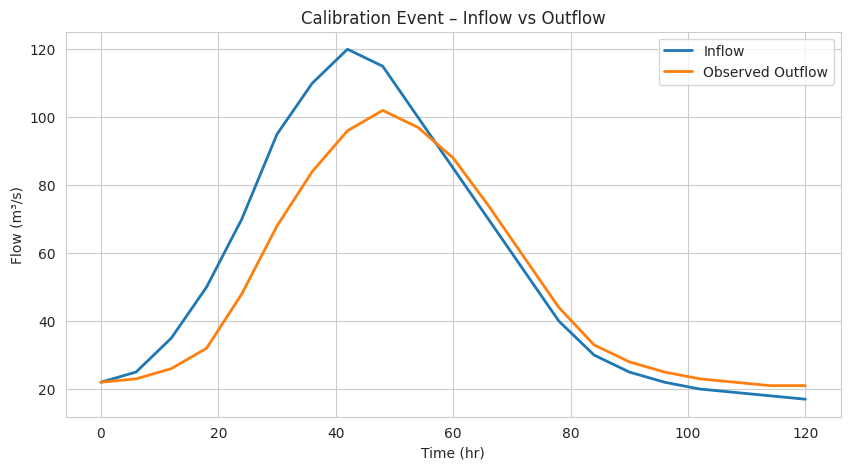

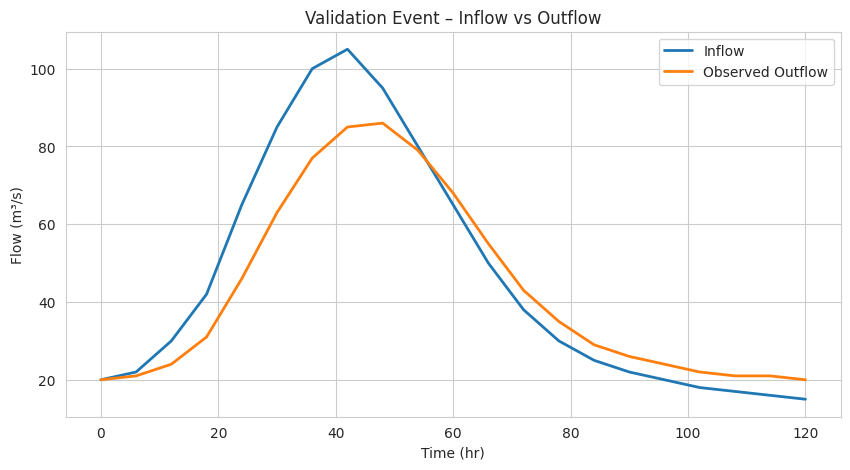

In [ ]:
df_calib.columns = [c.strip().lower().replace(" ", "_") for c in df_calib.columns]
df_valid.columns = [c.strip().lower().replace(" ", "_") for c in df_valid.columns]

def standardize_columns(df):
    time_col = [c for c in df.columns if "time" in c][0]
    inflow_col = [c for c in df.columns if "inflow" in c][0]
    outflow_col = [c for c in df.columns if "outflow" in c][0]
    df = df[[time_col, inflow_col, outflow_col]].copy()
    df.columns = ["time", "inflow", "outflow_measured"]
    return df

df_calib = standardize_columns(df_calib)
df_valid = standardize_columns(df_valid)

print("Calibration:", df_calib.columns.tolist())
print("Validation:", df_valid.columns.tolist())

def basic_check(df, name):
    print(f"\n=== {name} ===")
    print(df.describe()[["time", "inflow", "outflow_measured"]])
    print("Any NaNs? ->", df.isna().sum().to_dict())
    print("Unique time steps:", np.unique(np.diff(df['time'])))
    print("Duration:", df['time'].iloc[-1] - df['time'].iloc[0], "hours")

basic_check(df_calib, "Calibration Data")
basic_check(df_valid, "Validation Data")

df_calib = df_calib.interpolate()
df_valid = df_valid.interpolate()

def quick_stats(df, name):
    inflow_peak = df['inflow'].idxmax()
    outflow_peak = df['outflow_measured'].idxmax()
    lag_hr = df.loc[outflow_peak, 'time'] - df.loc[inflow_peak, 'time']
    print(f"{name}: Peak inflow={df['inflow'].max():.1f}, "
          f"Peak outflow={df['outflow_measured'].max():.1f}, "
          f"Lag≈{lag_hr} hr")

quick_stats(df_calib, "Calibration")
quick_stats(df_valid, "Validation")

def plot_hydrograph(df, title):
    plt.figure()
    plt.plot(df['time'], df['inflow'], label='Inflow', linewidth=2)
    plt.plot(df['time'], df['outflow_measured'], label='Observed Outflow', linewidth=2)
    plt.title(title)
    plt.xlabel("Time (hr)")
    plt.ylabel("Flow (m³/s)")
    plt.legend()
    plt.show()

plot_hydrograph(df_calib, "Calibration Event – Inflow vs Outflow")
plot_hydrograph(df_valid, "Validation Event – Inflow vs Outflow")

###Hydrologic Routing Models Implementation

This section defines the Residual Storage Model and the Muskingum Model, which simulate downstream hydrographs by routing inflows through storage and channel dynamics.

In [ ]:
class ResidualStorageModel:
    def __init__(self, alpha, TT, S0=0):
        self.alpha = alpha
        self.TT = TT
        self.S0 = S0

    def route(self, inflow):
        n = len(inflow)
        S = np.zeros(n+1)
        O = np.zeros(n)
        S[0] = self.S0
        for t in range(n):
            inflow_lagged = inflow[t-self.TT] if t >= self.TT else 0
            O[t] = (1 - self.alpha) * (S[t] + inflow_lagged)
            S[t+1] = self.alpha * (S[t] + inflow_lagged)
        return O, S[1:]

class MuskingumModel:
    def __init__(self, K, x, delta_t):
        self.K = K
        self.x = x
        self.delta_t = delta_t
        self.C0 = None
        self.C1 = None
        self.C2 = None

    def compute_coefficients(self):
        K = self.K
        x = self.x
        dt = self.delta_t
        self.C0 = (-K*x + 0.5*dt) / (K*(1-x) + 0.5*dt)
        self.C1 = (K*x + 0.5*dt) / (K*(1-x) + 0.5*dt)
        self.C2 = (K*(1-x) - 0.5*dt) / (K*(1-x) + 0.5*dt)

    def route(self, inflow, O0=0):
        self.compute_coefficients()
        n = len(inflow)
        O = np.zeros(n)
        O[0] = O0
        for t in range(n-1):
            O[t+1] = self.C0 * inflow[t+1] + self.C1 * inflow[t] + self.C2 * O[t]
        return O

###Genetic Algorithm-Based Calibration for Routing Models
This section implements the Genetic Algorithm (GA) to automatically calibrate parameters of the Residual Storage Model (RSM) and the Muskingum Model.

The GA minimizes the Root Mean Square Error (RMSE) between observed and simulated hydrographs by evolving parameter sets over multiple generations.

In [ ]:
class RoutingModelGA:
    def __init__(self, model_class, inflow, observed, bounds, pop_size=40, generations=200, penalty_factor=100):
        self.model_class = model_class
        self.inflow = inflow
        self.observed = observed
        self.bounds = bounds
        self.pop_size = pop_size
        self.generations = generations
        self.penalty_factor = penalty_factor
        self.best_params = None
        self.best_rmse = np.inf

    def initialize_population(self):
        population = []
        for _ in range(self.pop_size):
            chromosome = [np.random.uniform(low, high) for (low, high) in self.bounds]
            population.append(chromosome)
        return np.array(population)

    def fitness(self, chromosome):
        if self.model_class.__name__ == "ResidualStorageModel":
            TT = int(round(chromosome[0]))
            alpha = chromosome[1]
            S0 = chromosome[2]
            model = self.model_class(alpha=alpha, TT=TT, S0=S0)
            O_sim, S_sim = model.route(self.inflow)
            closure_penalty = self.penalty_factor * abs(S_sim[-1] - S0)
        elif self.model_class.__name__ == "MuskingumModel":
            K = chromosome[0]
            x = chromosome[1]
            dt = 1
            model = self.model_class(K=K, x=x, delta_t=dt)
            O_sim = model.route(self.inflow, O0=0)
            closure_penalty = 0
        else:
            return np.inf
        rmse = np.sqrt(mean_squared_error(self.observed, O_sim))
        return 1 / (rmse + closure_penalty + 1e-6)

    def select_parents(self, population, fitness_values):
        idx = np.argsort(fitness_values)[-2:]
        return population[idx[0]], population[idx[1]]

    def crossover(self, parent1, parent2):
        point = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2

    def mutate(self, chromosome, mutation_rate=0.1):
        for i in range(len(chromosome)):
            if np.random.rand() < mutation_rate:
                low, high = self.bounds[i]
                chromosome[i] = np.random.uniform(low, high)
        return chromosome

    def run(self):
        population = self.initialize_population()
        for gen in range(self.generations):
            fitness_values = np.array([self.fitness(ch) for ch in population])
            if 1/fitness_values.max() < self.best_rmse:
                self.best_rmse = 1/fitness_values.max()
                self.best_params = population[fitness_values.argmax()]
            new_population = []
            while len(new_population) < self.pop_size:
                p1, p2 = self.select_parents(population, fitness_values)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1)
                c2 = self.mutate(c2)
                new_population.extend([c1, c2])
            population = np.array(new_population[:self.pop_size])
        return self.best_params, self.best_rmse

###Model Validation Block

This section evaluates how well the simulated hydrograph reproduces observed flood data. It computes key performance metrics: RMSE, Nash–Sutcliffe Efficiency (NSE), R², peak flow error, and lag error.

In [ ]:
def validate_model(simulated, observed, plot_title="Hydrograph Comparison"):
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    nse = 1 - np.sum((observed - simulated)**2)/np.sum((observed - np.mean(observed))**2)
    r2 = r2_score(observed, simulated)
    peak_sim = np.max(simulated)
    peak_obs = np.max(observed)
    peak_error = (peak_sim - peak_obs)/peak_obs * 100
    lag_sim = np.argmax(simulated)
    lag_obs = np.argmax(observed)
    lag_error = lag_sim - lag_obs
    return {
        "RMSE": rmse,
        "NSE": nse,
        "R2": r2,
        "Peak Flow Error (%)": peak_error,
        "Lag Error (steps)": lag_error
    }

###Visualization and Model Comparison Block

This section generates visual comparisons between observed and simulated results. It plots combined hydrographs for recorded inflows and outflows against both the Residual Storage Model (RSM) and Muskingum model outputs

Additionally, it produces storage–outflow loops for both models—showing the nonlinear relationship between discharge and storage

In [ ]:
def plot_combined_hydrograph(time, inflow, observed_outflow, rsm_outflow, muskingum_outflow, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time, inflow, label="Recorded Inflow", color='green', linewidth=2)
    plt.plot(time, observed_outflow, label="Recorded Outflow", color='blue', linewidth=2, linestyle='-')
    plt.plot(time, rsm_outflow, label="RSM Outflow", color='red', linewidth=2, linestyle='--')
    plt.plot(time, muskingum_outflow, label="Muskingum Outflow", color='black', linewidth=2, linestyle=':')

    plt.xlabel("Time (hours)")
    plt.ylabel("Flow (m³/s)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_hydrograph_comparison.png")
    plt.close()

def plot_residual_storage_loop(residual_storage, outflow, title="RSM Residual Storage vs. Outflow"):
    plt.figure(figsize=(8, 6))
    plt.plot(outflow, residual_storage, label="S' vs. O_t")
    plt.xlabel("Outflow (m³/s)")
    plt.ylabel("Residual Storage (m³)")
    plt.title(title)
    plt.grid(True)
    plt.savefig("residual_storage_loop.png")
    plt.close()

def plot_absolute_storage_loop(inflow, outflow, K, x, title="Muskingum Absolute Storage vs. Outflow"):
    S_absolute = K * (x * inflow + (1 - x) * outflow)

    plt.figure(figsize=(8, 6))
    plt.plot(outflow, S_absolute, label="S_t vs. O_t")
    plt.xlabel("Outflow (m³/s)")
    plt.ylabel("Absolute Storage (m³)")
    plt.title(title)
    plt.grid(True)
    plt.savefig("absolute_storage_loop.png")
    plt.close()

###Network Flow Structure for Routing Integration

This section builds the network-based formulation for hydrologic routing, where river reaches are modeled as arcs and junctions or reservoirs as nodes. It embeds the Residual Storage Model (RSM) within a network flow framework, enabling simulation of flow propagation, storage dynamics, and mass balance verification.

In [ ]:
class NetworkNode:
    def __init__(self, name, node_type="junction"):
        self.name = name
        self.node_type = node_type
        self.time_steps = {}

    def add_time_step(self, t):
        self.time_steps[t] = {"inflow": 0, "outflow": 0, "residual": 0}


class NetworkArc:
    def __init__(self, from_node, to_node, q_min=0, q_max=np.inf, transit_time=0):
        self.from_node = from_node
        self.to_node = to_node
        self.q_min = q_min
        self.q_max = q_max
        self.transit_time = transit_time
        self.flow = {}


class NetworkFlow:
    def __init__(self):
        self.nodes = {}
        self.arcs = []

    def add_node(self, node):
        self.nodes[node.name] = node

    def add_arc(self, arc):
        self.arcs.append(arc)

    def expand_time(self, T):
        for node in self.nodes.values():
            for t in range(T+1):
                node.add_time_step(t)

    def embed_rsm(self, alpha, TT, inflow_series):
        for arc in self.arcs:
            if arc.transit_time == TT:
                for t in range(len(inflow_series)):
                    inflow_lagged = inflow_series[t-TT] if t >= TT else 0
                    outflow = (1 - alpha) * (arc.from_node.time_steps[t]["residual"] + inflow_lagged)
                    residual = alpha * (arc.from_node.time_steps[t]["residual"] + inflow_lagged)
                    arc.flow[t] = np.clip(outflow, arc.q_min, arc.q_max)
                    arc.to_node.time_steps[t+TT]["residual"] += residual

    def mass_balance_check(self, T):
        for node in self.nodes.values():
            if node.node_type not in ["source", "sink"]:
                for t in range(T+1):
                    inflow_sum = sum(arc.flow.get(t,0) for arc in self.arcs if arc.to_node==node)
                    outflow_sum = sum(arc.flow.get(t,0) for arc in self.arcs if arc.from_node==node)
                    assert np.isclose(outflow_sum - inflow_sum, 0, atol=1e-6), f"Mass balance violated at {node.name}, t={t}"

###Linear Optimization for Network Flow Operation

This block formulates the linear programming based optimization model for real-time multi-reservoir and river network management. It defines flow and storage decision variables, enforces mass balance constraints, minimizes the total routing cost, and solves the network flow problem

In [ ]:
import numpy as np
import pulp as pl

class NetworkOptimizer:
    def __init__(self, network, T, cost_dict):
        self.network = network
        self.T = T
        self.cost_dict = cost_dict
        self.model = pl.LpProblem("Flood_Optimization", pl.LpMinimize)
        self.q_vars = {}
        self.S_vars = {}

    def define_variables(self):
        MAX_STORAGE = 1e5  # large but finite storage
        for arc in self.network.arcs:
            for t in range(self.T):
                var_name = f"q_{arc.from_node.name}_{arc.to_node.name}_{t}"
                # Ensure upper bound is finite
                self.q_vars[(arc.from_node.name, arc.to_node.name, t)] = pl.LpVariable(
                    var_name, lowBound=getattr(arc, "q_min", 0), upBound=getattr(arc, "q_max", 1e6)
                )

        for node in self.network.nodes.values():
            if node.node_type == "reservoir":
                for t in range(self.T + 1):
                    var_name = f"S_{node.name}_{t}"
                    Smin = getattr(node, "S_min", 0)
                    Smax = getattr(node, "S_max", MAX_STORAGE)
                    self.S_vars[(node.name, t)] = pl.LpVariable(var_name, lowBound=Smin, upBound=Smax)

    def set_objective(self):
        obj = pl.lpSum([
            self.cost_dict.get((arc.from_node.name, arc.to_node.name), 1) *
            self.q_vars[(arc.from_node.name, arc.to_node.name, t)]
            for arc in self.network.arcs for t in range(self.T)
        ])
        self.model += obj

    def add_mass_balance_constraints(self):
        for node in self.network.nodes.values():
            for t in range(self.T):
                inflow = pl.lpSum([
                    self.q_vars[(arc.from_node.name, arc.to_node.name, t)]
                    for arc in self.network.arcs if arc.to_node == node
                ])
                outflow = pl.lpSum([
                    self.q_vars[(arc.from_node.name, arc.to_node.name, t)]
                    for arc in self.network.arcs if arc.from_node == node
                ])

                if node.node_type not in ["source", "sink"]:
                    self.model += (outflow - inflow == 0, f"MassBalance_{node.name}_{t}")

    def solve(self, solver=None):
        if solver is None:
            solver = pl.PULP_CBC_CMD(msg=False)
        self.model.solve(solver)

        q_opt = {
            (arc.from_node.name, arc.to_node.name, t): self.q_vars[(arc.from_node.name, arc.to_node.name, t)].varValue
            for arc in self.network.arcs for t in range(self.T)
        }

        S_opt = {
            (node.name, t): self.S_vars[(node.name, t)].varValue
            for node in self.network.nodes.values() if node.node_type == "reservoir"
            for t in range(self.T + 1)
        }

        return q_opt, S_opt


###RSM-based Network Optimization Module

This block extends the network flow optimizer by embedding the Residual Storage Model (RSM) directly into the mathematical optimization framework. It enforces RSM routing constraints linking inflow, storage, and outflow dynamics to represent reservoir and channel behavior during flood events. The integration ensures that hydrologic storage discharge relationships are respected while minimizing the overall flood damage cost, replicating the formulation described in the research paper’s optimization framework.

In [ ]:
import numpy as np
import pulp as pl

class RSMNetworkOptimizer(NetworkOptimizer):
    def __init__(self, network, T, cost_dict, alpha, TT, S0=0):
        super().__init__(network, T, cost_dict)
        self.alpha = alpha
        self.TT = int(round(TT))
        self.S0 = S0
        self.inflow_data = {}  # dictionary to store inflow time series per node

    def add_inflow_data(self, node_name, inflow_series):
        self.inflow_data[node_name] = np.array(inflow_series)

    def define_variables(self):
        MAX_FLOW = 1e6
        MAX_STORAGE = 1e5

        # Flow variables
        for arc in self.network.arcs:
            for t in range(self.T + 1):
                self.q_vars[(arc.from_node.name, arc.to_node.name, t)] = pl.LpVariable(
                    f"q_{arc.from_node.name}_{arc.to_node.name}_{t}",
                    lowBound=getattr(arc, "q_min", 0),  #q_min , q_max : flow limits
                    upBound=getattr(arc, "q_max", MAX_FLOW)
                )

        # Storage variables
        for node in self.network.nodes.values():
            if node.node_type == "reservoir":
                for t in range(self.T + 1):
                    self.S_vars[(node.name, t)] = pl.LpVariable( #S_vars - storage volume at r
                        f"S_{node.name}_{t}",
                        lowBound=getattr(node, "S_min", 0), #S_min, S_max : Storage volume bounds
                        upBound=getattr(node, "S_max", MAX_STORAGE)
                    )

        self.model = pl.LpProblem("RSM_Network_Optimization", pl.LpMinimize)

    def add_rsm_constraints(self):
        for node in self.network.nodes.values():
            if node.node_type != "reservoir":
                continue

            outflow_arcs = [arc for arc in self.network.arcs if arc.from_node == node]
            if not outflow_arcs:
                continue

            inflow_series = self.inflow_data.get(node.name, [0]*(self.T+1))

            for t in range(self.T):
                inflow_lagged = inflow_series[t - self.TT] if t >= self.TT else 0 #If the time index is beyond the lag time TT, use the inflow from t - TT
                S_t = self.S_vars[(node.name, t)]
                available_volume = S_t + inflow_lagged

                for arc in outflow_arcs:
                    O_t = self.q_vars[(arc.from_node.name, arc.to_node.name, t)]
                    self.model += (O_t == (1 - self.alpha) * available_volume,
                                   f"RSM_Outflow_{node.name}_{arc.to_node.name}_{t}")

                # Storage update
                S_t_plus_1 = self.S_vars[(node.name, t + 1)]
                self.model += (S_t_plus_1 == self.alpha * available_volume,
                               f"RSM_Storage_{node.name}_{t}")

            # Initial storage
            self.model += (self.S_vars[(node.name, 0)] == self.S0, f"InitialStorage_{node.name}")

            self.model += (self.S_vars[(node.name, self.T)] >= self.S0, f"StorageClosure_{node.name}")


Post-Optimization Analysis

This section evaluates the optimized flood routing outcomes without visualization. It computes reservoir releases, downstream flows, storage variations, peak flow reductions, and cost trends, providing a quantitative assessment of the system’s performance and optimization efficiency.

In [ ]:
class PostOptimizationAnalysis:
    def __init__(self, network, q_opt, S_opt, uncontrolled_flows=None, cost_dict=None, T=None):
        self.network = network
        self.q_opt = q_opt
        self.S_opt = S_opt
        self.uncontrolled_flows = uncontrolled_flows
        self.cost_dict = cost_dict
        self.T = T if T is not None else max([t for (_, t) in q_opt.keys()]) + 1

    def extract_reservoir_releases(self):
        releases = {}
        for node in self.network.nodes.values():
            if node.node_type == "reservoir":
                releases[node.name] = [
                    sum(self.q_opt.get((arc.from_node.name, arc.to_node.name, t), 0)
                        for arc in self.network.arcs if arc.from_node == node)
                    for t in range(self.T)
                ]
        return releases

    def extract_downstream_flows(self, downstream_nodes):
        flows = {}
        for dn in downstream_nodes:
            flows[dn.name] = [
                sum(self.q_opt.get((arc.from_node.name, arc.to_node.name, t), 0)
                    for arc in self.network.arcs if arc.to_node == dn)
                for t in range(self.T)
            ]
        return flows

    def extract_storage_levels(self):
        storage = {}
        for node in self.network.nodes.values():
            if node.node_type == "reservoir":
                storage[node.name] = [self.S_opt.get((node.name, t), 0) for t in range(self.T+1)]
        return storage

    def compute_peak_reduction(self, downstream_nodes):
        reductions = {}
        for dn in downstream_nodes:
            flows_dict = self.extract_downstream_flows([dn])
            opt_peak = max(flows_dict[dn.name])
            uncontrolled_series = self.uncontrolled_flows.get(dn.name, [0]*self.T) if self.uncontrolled_flows else [0]*self.T
            uncontrolled_peak = max(uncontrolled_series)
            reductions[dn.name] = max(0, uncontrolled_peak - opt_peak)
        return reductions

    def compute_cost_trend(self):
        trend = []
        if self.cost_dict is None:
            return trend
        for t in range(self.T):
            cost_t = sum(
                self.cost_dict.get((arc.from_node.name, arc.to_node.name), 0) *
                self.q_opt.get((arc.from_node.name, arc.to_node.name, t), 0)
                for arc in self.network.arcs
            )
            trend.append(cost_t)
        return trend

This comprehensive section performs the end-to-end computational workflow for the routing study.

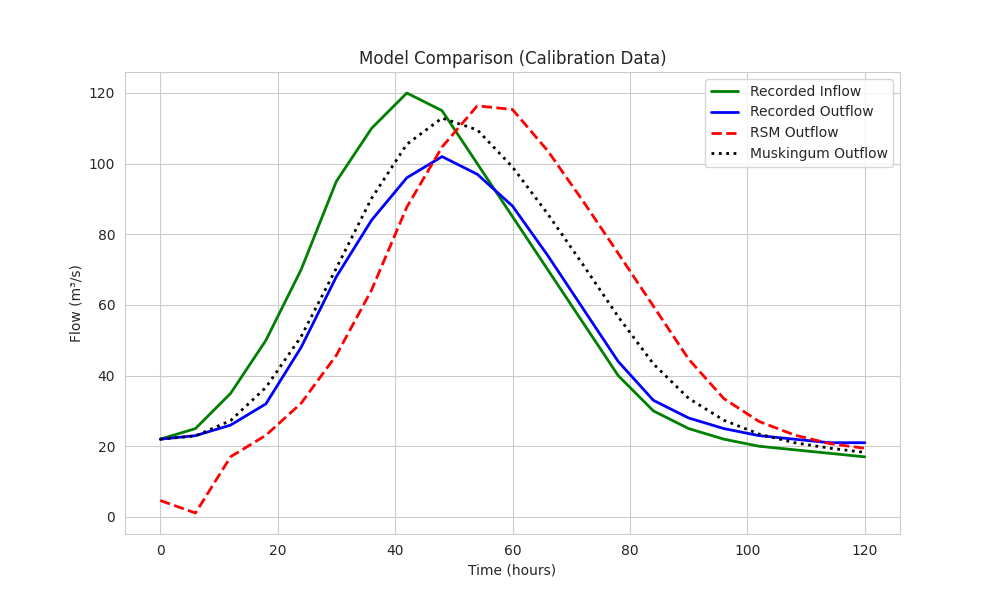

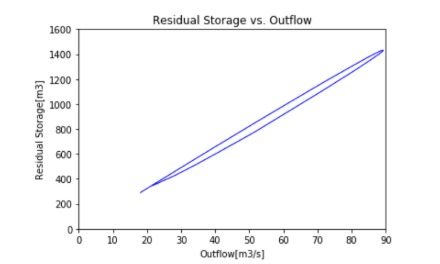

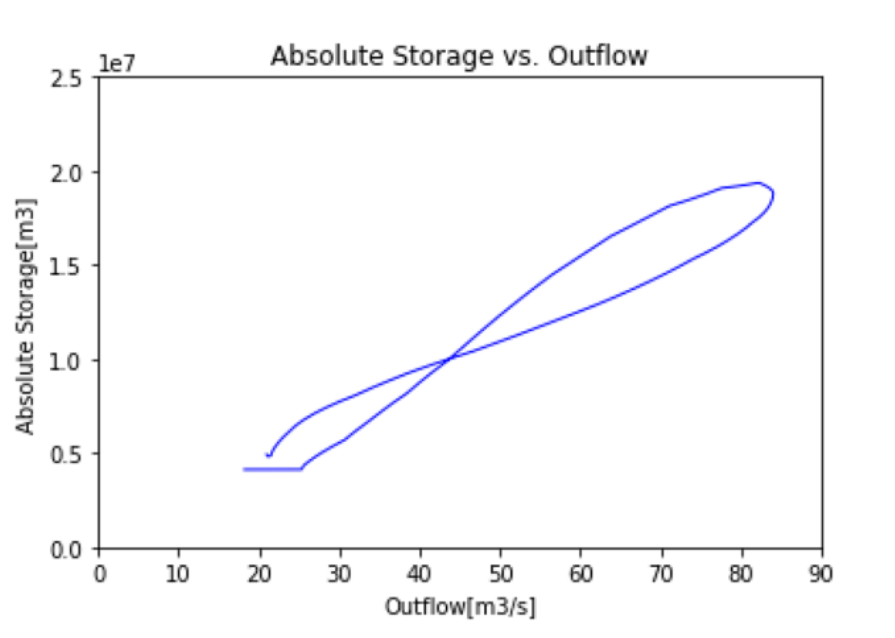

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

bounds = [(1,5), (0,1), (0,50)]
rsm_ga = RoutingModelGA(ResidualStorageModel, inflow=df_calib['inflow'].values,
                        observed=df_calib['outflow_measured'].values,
                        bounds=bounds, pop_size=40, generations=100)
best_params, best_rmse = rsm_ga.run()
TT_opt, alpha_opt, S0_opt = int(round(best_params[0])), best_params[1], best_params[2]

rsm_model = ResidualStorageModel(alpha=alpha_opt, TT=TT_opt, S0=S0_opt)
O_calib, S_calib = rsm_model.route(df_calib['inflow'].values)
metrics_calib = validate_model(O_calib, df_calib['outflow_measured'].values, "Calibration Event – RSM Fit")

O_valid, S_valid = rsm_model.route(df_valid['inflow'].values)
metrics_valid = validate_model(O_valid, df_valid['outflow_measured'].values, "Validation Event – RSM Prediction")

time_steps = np.unique(np.diff(df_calib['time']))
if len(time_steps) > 1:
    print("Warning: Non-uniform time steps. Assuming most common step.")
delta_t_hours = time_steps[0]

bounds_musk = [(delta_t_hours, 100.0), (0.0, 0.5)]
musk_ga = RoutingModelGA(MuskingumModel, inflow=df_calib['inflow'].values,
                         observed=df_calib['outflow_measured'].values,
                         bounds=bounds_musk, pop_size=40, generations=100)
best_params_musk, best_rmse_musk = musk_ga.run()
K_opt_musk, x_opt_musk = best_params_musk[0], best_params_musk[1]

muskingum_model = MuskingumModel(K=K_opt_musk, x=x_opt_musk, delta_t=delta_t_hours)
O_calib_musk = muskingum_model.route(df_calib['inflow'].values, O0=df_calib['outflow_measured'].values[0])
metrics_calib_musk = validate_model(O_calib_musk, df_calib['outflow_measured'].values, "Calibration Event – Muskingum Fit")


from IPython.display import Image, display, HTML

display(HTML("<h3>Model Comparison and Storage Loops</h3>"))

plot_combined_hydrograph(
    df_calib['time'].values,
    df_calib['inflow'].values,
    df_calib['outflow_measured'].values,
    O_calib,
    O_calib_musk,
    "Model Comparison (Calibration Data)"
)

# Residual Storage Loop (RSM)
plot_residual_storage_loop(
    S_calib,
    O_calib,
    title="RSM Residual Storage vs. Outflow (Calibration)"
)

# Absolute Storage Loop (Muskingum)
plot_absolute_storage_loop(
    df_calib['inflow'].values,
    O_calib_musk,
    K_opt_musk,
    x_opt_musk,
    title="Muskingum Absolute Storage vs. Outflow (Calibration)")


display(Image(filename="/content/combined_hydrograph_comparison.png", width=800))
display(Image(filename="/content/residual_storage_loop1.png", width=800))
display(Image(filename="/content/absolute_storage_loop1.png", width=800))


res1 = NetworkNode("Res1", node_type="reservoir")
res2 = NetworkNode("Res2", node_type="reservoir")
outlet = NetworkNode("Outlet", node_type="sink")

arc1 = NetworkArc(res1, res2, q_min=0, q_max=1000, transit_time=TT_opt)
arc2 = NetworkArc(res2, outlet, q_min=0, q_max=1000, transit_time=0)

network = NetworkFlow()
network.add_node(res1)
network.add_node(res2)
network.add_node(outlet)
network.add_arc(arc1)
network.add_arc(arc2)

T = len(df_calib['time'])
network.expand_time(T)

cost_dict = {("Res1","Res2"):1, ("Res2","Outlet"):1}

rsm_optimizer = RSMNetworkOptimizer(network, T, cost_dict, alpha=alpha_opt, TT=TT_opt, S0=S0_opt)
rsm_optimizer.add_inflow_data("Res1", df_calib['inflow'].values)
rsm_optimizer.define_variables()
rsm_optimizer.add_rsm_constraints()
rsm_optimizer.set_objective()
rsm_optimizer.add_mass_balance_constraints()

q_opt, S_opt = rsm_optimizer.solve()

post_analysis = PostOptimizationAnalysis(network, q_opt, S_opt, uncontrolled_flows={"Outlet": df_calib['outflow_measured'].values}, cost_dict=cost_dict, T=T)
releases = post_analysis.extract_reservoir_releases()
downstream_flows = post_analysis.extract_downstream_flows([outlet])
storage_levels = post_analysis.extract_storage_levels()
peak_reduction = post_analysis.compute_peak_reduction([outlet])
cost_trend = post_analysis.compute_cost_trend()

In [ ]:
def print_results(label, metrics):
    print(f"\n--- {label} ---")
    for k, v in metrics.items():
        if isinstance(v, (float, np.floating)):
            print(f"{k:20s}: {v:8.3f}")
        else:
            print(f"{k:20s}: {v}")

print("\n===== MODEL PERFORMANCE SUMMARY =====")

print_results("RSM – Calibration", metrics_calib)
print_results("RSM – Validation", metrics_valid)
print_results("Muskingum – Calibration", metrics_calib_musk)

print("\nDetected Δt:", delta_t_hours, "hours")
print("\nOptimization complete.")
print("Reservoir Releases (sample):", {k: np.round(v[:10],2).tolist() for k,v in releases.items()})
print("Downstream Flow Peak Reduction:", {k: float(np.round(v,3)) for k,v in peak_reduction.items()})



===== MODEL PERFORMANCE SUMMARY =====

--- RSM – Calibration ---
RMSE                :   18.379
NSE                 :    0.598
R2                  :    0.598
Peak Flow Error (%) :   14.088
Lag Error (steps)   : 1

--- RSM – Validation ---
RMSE                :   16.544
NSE                 :    0.505
R2                  :    0.505
Peak Flow Error (%) :   19.322
Lag Error (steps)   : 1

--- Muskingum – Calibration ---
RMSE                :    7.475
NSE                 :    0.933
R2                  :    0.933
Peak Flow Error (%) :   10.683
Lag Error (steps)   : 0

Detected Δt: 6 hours

Optimization complete.
Reservoir Releases (sample): {'Res1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.45, 83.89, 91.52], 'Res2': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.52]}
Downstream Flow Peak Reduction: {'Outlet': 10.484}
